# Athlete v Segment
This notebook details the algorithm for determining whether an athlete can get the fastest known time on a Strava segment based on their 5k PR. This algorithm takes an unsophisticated approach that will serve as a baseline for comparing to a much more complex Dynamic Time Warping alg.  
 The general steps for this alg are:

1) Take in athlete PR
2) Convert to percentage of world record
3) Create other expected perfomances for different distances
4) Plot on this as a "performance curve" graph
5) Take GAP (Grade adjusted pace) of Segment
6) Plot segment GAP on graph, see if over or under curve

In [5]:
import datetime
import json 
import numpy as np
import selenium

from matplotlib import pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By

In [6]:
# WR times for different distances 
WR_800 = datetime.timedelta(minutes=1,seconds=40)
WR_MILE = datetime.timedelta(minutes=3,seconds=43)
WR_2K = datetime.timedelta(minutes=4,seconds=44) 
WR_3K = datetime.timedelta(minutes=7,seconds=20)
WR_5K = datetime.timedelta(minutes=12,seconds=35)
WR_10K = datetime.timedelta(minutes=26,seconds=24)
WR_10M = datetime.timedelta(minutes=44,seconds=24)
WR_MARATHON = datetime.timedelta(hours=2,minutes=1,seconds=39)

In [7]:
def pr_to_wr_percentage(athlete_5k_pr:datetime.time):  
    return WR_5K.total_seconds() / athlete_5k_pr.total_seconds()

def get_equivalent_time_all_records(wr_percentage):
    # Rigels constant accounts for speciality, 
    # ie someone who trains for the 5k won't be equally as good at the 800m
    rigels_constant = 1.06
    t_0 = 0
    t_800 = WR_800.total_seconds() + (WR_800.total_seconds() * (1-wr_percentage)) * rigels_constant
    t_mile = WR_MILE.total_seconds() + (WR_MILE.total_seconds() * (1-wr_percentage))* rigels_constant
    t_2k = WR_2K.total_seconds() + (WR_2K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_3k = WR_3K.total_seconds() + (WR_3K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_5k = WR_5K.total_seconds() + (WR_5K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_10k = WR_10K.total_seconds() + (WR_10K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_10m = WR_10M.total_seconds() + (WR_10M.total_seconds() * (1-wr_percentage))* rigels_constant
    t_mara = WR_MARATHON.total_seconds() + (WR_MARATHON.total_seconds() * (1-wr_percentage))* rigels_constant
    return t_0,t_800,t_mile,t_2k,t_3k,t_5k,t_10k,t_10m,t_mara

In [8]:
# testing with my 5k pr
pr = datetime.timedelta(minutes=14,seconds=46)
percentage = pr_to_wr_percentage(pr)
print(get_equivalent_time_all_records(percentage))

(0, 115.6726862302483, 257.95009029345374, 328.5104288939052, 508.95981941309253, 873.3287810383747, 1832.2553498871332, 3081.520361173815, 8442.949367945825)


These equivalent times feel pretty accurate to me, maybe a little bit on the faster side 

### Plotting an athletes performance curve

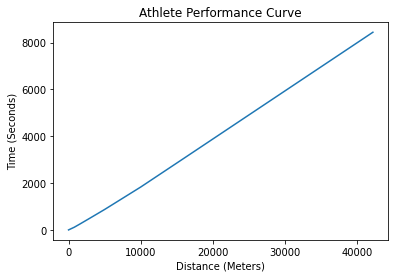

In [9]:
distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
def plot_athlete_perfomance_curve(equivalent_event_times):
    meters = distances
    time = equivalent_event_times
    plt.xlabel("Distance (Meters)")
    plt.ylabel("Time (Seconds)")
    plt.title("Athlete Performance Curve")
    plt.plot(meters,time)
    plt.show()
    return meters,time
    
equivalent_times = get_equivalent_time_all_records(percentage)
plot_data = plot_athlete_perfomance_curve(equivalent_times)


### GAP Equation 1.0
GAP equation is is 10s per 44ft per 1609.34m  
So GAP pace change = -10 * ((elevation gain/drop/#miles) * (#miles)/44)  
In meteres = -10 * ((elevation gain/drop/(distance/1609.44)) * ((distance/1609.4)/44)    
GAP is 10/160.09 seconds per 44/160.09 ft gain/drop per 10m 

Potentially could try breaking down a segment into small chunks and adding up all their GAPs. 

In [10]:
def calc_GAP(distance,time,elevation_gain):
    meters_to_miles_conversion = 1/1609.44
    ft_to_meters_conversion = 1/3.281
    pace = time/distance
    GAP_addition = -10 * (elevation_gain/(distance*meters_to_miles_conversion)) * ((distance*meters_to_miles_conversion)/(44*ft_to_meters_conversion)) 
    GAP = pace + GAP_addition/1609.44
    return GAP

In [11]:
# takes in athlete times at various distances, segment distance and time
def calc_pace_for_segment_and_athlete(plot_data,segment_data):
    athlete_time = np.interp(segment_data[0],plot_data[0],plot_data[1])
    
    athlete_pace = athlete_time/(segment_data[0]/1000) # pace in seconds/km
    segment_pace =  segment_data[1]/(segment_data[0]/1000) # pace in seconds/km
    return str(datetime.timedelta(seconds=athlete_pace)),str(datetime.timedelta(seconds=segment_pace))

In [12]:
# Determine whether a point is above or below graph line
def plot_segment_on_athlete_curve(plot_data,segment_data,segment_name):
    plt.xlabel("Distance (Meters)")
    plt.ylabel("Time (Seconds)")
    plot_x_nearest_to_segment = min(plot_data[0], key=lambda x:abs(x-segment_data[0]))
    plot_y_nearest_to_segment = min(plot_data[1], key=lambda x:abs(x-segment_data[1]))
    # find a good axis window
    axis_range = 300 # 300 seems reasonable for most graphs I've tested 
    plt.axis([segment_data[0]-axis_range,segment_data[0]+axis_range,
    min(plot_x_nearest_to_segment,segment_data[1]-axis_range),max(plot_y_nearest_to_segment,segment_data[1]+axis_range)])
    
    plt.scatter([segment_data[0]],[segment_data[1]],color="red",label=f"{segment_name} Segment")
    plt.plot(plot_data[0],plot_data[1],label="Athlete")
    plt.legend()
    plt.show()

    # calculate the paces for each
    athlete_pace,segment_pace = calc_pace_for_segment_and_athlete(plot_data,segment_data)
    print(f"Athlete pace: {athlete_pace} m/km")
    print(f"Segment pace: {segment_pace} m/km")

# Calculate cross product to determine if above or below plot line
def calc_above_or_below_plt_line(plot_data,segment_data):
    xA = segment_data[0]
    yA = segment_data[1]
    x1,x2,y1,y2 = 0,0,0,0
    for distance_index in range(len(plot_data[0])):
        # break if you've found closest points on athlete curve to segement 
        if plot_data[0][distance_index] > xA:
            x1 = plot_data[0][distance_index]
            y1 = plot_data[1][distance_index]
            x2 = plot_data[0][distance_index-1]
            y2 = plot_data[1][distance_index-1]
            break
    v1 = (x2-x1, y2-y1)   
    v2 = (x2-xA, y2-yA)   
    cross_product = v1[0]*v2[1] - v1[1]*v2[0] 
    if cross_product > 0:
        print('Athlete is faster than segment')
    elif cross_product < 0:
        print('Athlete is slower than segment')
    else:
        print('Athlete is exactly as fast as segment')

#### Getting pre-downloaded segment data from files

In [13]:
def get_segment_data_from_file(filename,segment_id):
        with open(filename,"r") as file:
                segment_data_dict = json.load(file)
        return segment_data_dict[segment_id]

def convert_segment_data_to_floats(segment_data:list):
        meters = float(segment_data[0][:-2])*1000
        hours_10s  = int(segment_data[1][-8]) if len(segment_data[1]) > 7 else 0
        hours_1s  = int(segment_data[1][-7]) if len(segment_data[1]) > 6 else 0
        mins_10s =  int(segment_data[1][-5]) if len(segment_data[1]) > 4 else 0
        mins_1s  = int(segment_data[1][-4]) if len(segment_data[1]) > 3 else 0
        seconds_10s = int(segment_data[1][-2]) if len(segment_data[1]) > 1 else 0
        seconds_1s = int(segment_data[1][-1]) if len(segment_data[1]) > 0 else 0
        total_seconds = (36000*hours_10s)+(3600*hours_1s)+(600*mins_10s)+(60*mins_1s)+ (10*seconds_10s) + seconds_1s
        evelation_gain = int(segment_data[2][:-1])
        return meters,total_seconds,evelation_gain


In [14]:
segment_data = get_segment_data_from_file("data/general_segment_data/scraped_segment_data.json","1439652")
print(segment_data)
distance,time,gain = convert_segment_data_to_floats(segment_data)
print(distance,time,gain)
grade_adjusted_time = calc_GAP(distance,time,gain) * distance
print(grade_adjusted_time)

['1.88km', '5:40', '4m']
1880.0 340 4
336.5158519281693


Athlete is faster than segment


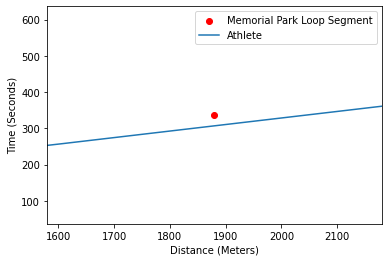

Athlete pace: 0:02:43.220788 m/km
Segment pace: 0:02:58.997794 m/km


In [15]:
segment_data = (distance,grade_adjusted_time) # distance,time
calc_above_or_below_plt_line(plot_data,segment_data)
plot_segment_on_athlete_curve(plot_data,segment_data,"Memorial Park Loop")

### Putting attempt V1 all in one function

In [16]:
# pr given as timedelta object
def get_athlete_vs_segment(athlete_5k_pr,segment_id,segment_name):
    percentage = pr_to_wr_percentage(athlete_5k_pr)
    equivalent_times = get_equivalent_time_all_records(percentage)
    plot_distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
    segment_data = get_segment_data_from_file("data/general_segment_data/scraped_segment_data.json",segment_id)
    print(segment_data)
    distance,time,gain = convert_segment_data_to_floats(segment_data)
    grade_adjusted_time = calc_GAP(distance,time,gain) * distance
    print(time)
    print(grade_adjusted_time)
    segment_data = (distance,grade_adjusted_time) # distance,time
    calc_above_or_below_plt_line((distances,equivalent_times),segment_data)
    plot_segment_on_athlete_curve((distances,equivalent_times),segment_data,segment_name)
    

['4.96km', '15:16', '38m']
916
828.6739057741146
Athlete is slower than segment


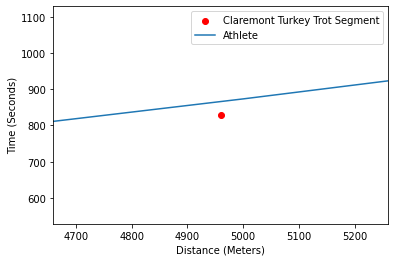

Athlete pace: 0:02:54.605121 m/km
Segment pace: 0:02:47.071352 m/km


In [17]:
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "6105319"
segment_name = "Claremont Turkey Trot"
get_athlete_vs_segment(pr,segment_id,segment_name)


#  GAP 1.0 Conclusions:
Looks like this GAP formula is pretty agressive. I think it probably works better for larger elevations, but it seems unfair to drop 30s per mile on a 3 mile run with 132ft gain. I think I'll need a better GAP equation.

# GAP Equation 2.0
This equation says that for every 1% grade in elevation, there is a 12-15s decrease per mile
In km's that 7.46-9.32s

In [19]:
# returns an upper or lower bound for GAP
def calc_GAP_2(distance,time,elevation_gain):
    grade = (elevation_gain/distance) * 100
    grade_adjusted_time_low = time - ((grade * 7.46/1000) * distance)  
    grade_adjusted_time_high = time - ((grade * 9.32/1000) * distance)
    return grade_adjusted_time_low,grade_adjusted_time_high

In [22]:
# pr given as timedelta object
def get_athlete_vs_segment_v2(athlete_5k_pr,segment_id,segment_name):
    percentage = pr_to_wr_percentage(athlete_5k_pr)
    equivalent_times = get_equivalent_time_all_records(percentage)
    plot_distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
    segment_data = get_segment_data_from_file("data/general_segment_data/scraped_segment_data.json",segment_id)
    print(f"Segment data: {segment_data}")
    distance,time,gain = convert_segment_data_to_floats(segment_data)
    grade_adjusted_time,time2 = calc_GAP_2(distance,time,gain)
    print(f"Seconds: {time}")
    print(f"Grade Adjusted Seconds {grade_adjusted_time}")
    print(f"Time reduction {time-grade_adjusted_time}")
    segment_data = (distance,grade_adjusted_time) # distance,time
    calc_above_or_below_plt_line((distances,equivalent_times),segment_data)
    plot_segment_on_athlete_curve((distances,equivalent_times),segment_data,segment_name)

Segment data: ['6.25km', '18:22', '66m']
Seconds: 1102
Grade Adjusted Seconds 1052.764
Time reduction 49.236000000000104
Athlete is slower than segment


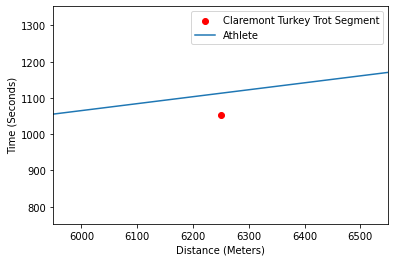

Athlete pace: 0:02:58.089668 m/km
Segment pace: 0:02:48.442240 m/km


In [23]:
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "2588795"
segment_name = "Claremont Turkey Trot"
get_athlete_vs_segment_v2(pr,segment_id,segment_name)

Segment data: ['6.25km', '18:22', '66m']
Seconds: 1102
Grade Adjusted Seconds 1052.764
Time reduction 49.236000000000104
Athlete is slower than segment


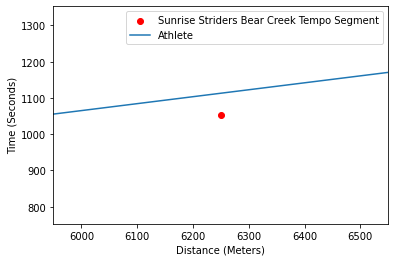

Athlete pace: 0:02:58.089668 m/km
Segment pace: 0:02:48.442240 m/km


In [25]:
segment_id = "2588795"
segment_name = "Sunrise Striders Bear Creek Tempo"
get_athlete_vs_segment_v2(pr,segment_id,segment_name)

These results make sense. I don't think I would be able to get that Bear Creek segment.

# On demand segment comparison
Decoupling segment search from my predownloaded set. Instead using selenium to scrape segments off the website in real time. This is not a violation of Strava TOS as I am making roughly as many requests as a human could make (1 every couple seconds or so)

In [28]:
def get_segment_distance_time_grade(segment_id):
    driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')
    url = f"https://www.strava.com/segments/{segment_id}?filter=overall"
    driver.get(url)
    # get elements by XPATH
    distance_element = driver.find_element(By.XPATH,'//*[@id="segment"]/div/div[3]/ul/li[1]/div/b')
    grade_element = driver.find_element(By.XPATH,'//*[@id="segment"]/div/div[3]/ul/li[3]/div/b')
    try:
        # check if there is a VAM
         leader_time_element = driver.find_element(By.XPATH,'//*[@id="segment-leaderboard"]/div/table/tbody/tr[1]/td[5]')
    except Exception:
         leader_time_element = driver.find_element(By.XPATH,'//*[@id="segment-leaderboard"]/div/table/tbody/tr[1]/td[4]')
    
    return distance_element.text,leader_time_element.text,grade_element.text


In [29]:
def convert_segment_data_to_floats_v2(segment_data:list):
        # need to remove all commas
        new_segment_data = []
        for data in segment_data:
                new_segment_data.append(data.replace(",",""))
        segment_data = new_segment_data
        
        meters = float(segment_data[0][:-2])*1000
        hours_10s  = int(segment_data[1][-8]) if len(segment_data[1]) > 7 else 0
        hours_1s  = int(segment_data[1][-7]) if len(segment_data[1]) > 6 else 0
        mins_10s =  int(segment_data[1][-5]) if len(segment_data[1]) > 4 else 0
        mins_1s  = int(segment_data[1][-4]) if len(segment_data[1]) > 3 else 0
        seconds_10s = int(segment_data[1][-2]) if len(segment_data[1]) > 1 else 0
        seconds_1s = int(segment_data[1][-1]) if len(segment_data[1]) > 0 else 0
        total_seconds = (36000*hours_10s)+(3600*hours_1s)+(600*mins_10s)+(60*mins_1s)+ (10*seconds_10s) + seconds_1s
        avg_grade = float(segment_data[2][:-1])
        return meters,total_seconds,avg_grade

In [30]:
# Simpler GAP function that uses grade instead of elevation gain
def gap_v2_with_grade(distance,time,grade):
    # add a different time for negative elevation
    if grade < 0:
        grade_adjusted_time_low = time - ((grade * 4.97/1000) * distance)  
        grade_adjusted_time_high = grade_adjusted_time_low
    else:
        grade_adjusted_time_low = time - ((grade * 7.46/1000) * distance)  
        grade_adjusted_time_high = time - ((grade * 9.32/1000) * distance)
    return grade_adjusted_time_low,grade_adjusted_time_high
    

In [31]:
def get_athlete_v_segment(pr_5k,segment_id,segment_name=""):
    # get segment data
    distance,time,grade = get_segment_distance_time_grade(segment_id)
    distance,time,grade = convert_segment_data_to_floats_v2([distance,time,grade])
    grade_adjusted_time_low,grade_adjusted_time_high = gap_v2_with_grade(distance,time,grade)
    # get athlete data
    percentage = pr_to_wr_percentage(pr)
    equivalent_times = get_equivalent_time_all_records(percentage)
    # plot both
    plot_distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
    segment_data = (distance,grade_adjusted_time_low)
    calc_above_or_below_plt_line((plot_distances,equivalent_times),segment_data)
    plot_segment_on_athlete_curve((plot_distances,equivalent_times),segment_data,segment_name)  

### Initial Testing/Verification

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


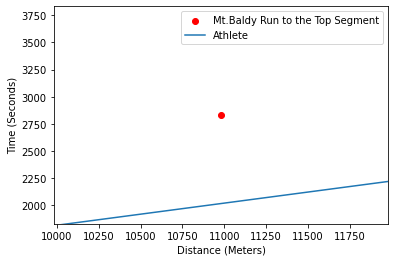

Athlete pace: 0:03:03.750567 km/s
Segment pace: 0:04:17.861454 km/s


In [33]:
import datetime
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "2298308"
segment_name = "Mt.Baldy Run to the Top"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_27920\2936833739.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


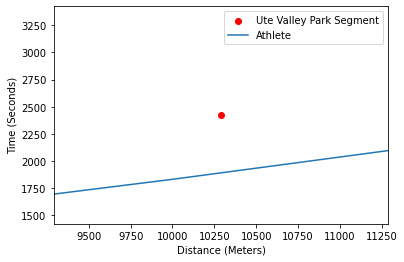

Athlete pace: 0:03:03.839744 km/s
Segment pace: 0:03:55.482423 km/s


In [ ]:
segment_id = "27001396"
segment_name = "Ute Valley Park"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_27920\2936833739.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


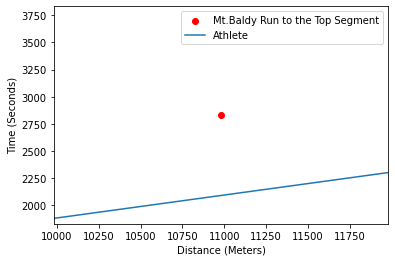

Athlete pace: 0:03:10.514522 km/s
Segment pace: 0:04:17.861454 km/s


In [ ]:
# Lets see if walt can get it 
pr = datetime.timedelta(minutes=15,seconds=20)
segment_id = "2298308"
segment_name = "Mt.Baldy Run to the Top"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


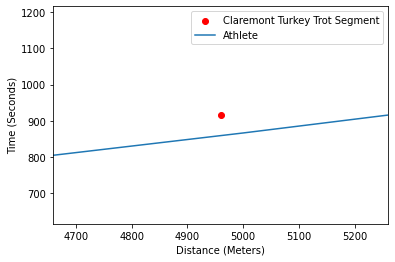

Athlete pace: 0:02:53.266015 m/km
Segment pace: 0:03:04.677419 m/km


In [55]:
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "6105319"
segment_name = "Claremont Turkey Trot"
get_athlete_v_segment(pr,segment_id,segment_name)

# Verifying Results
Comparing against segments I've already accomplished to see if my alg predicts if I would get them.

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


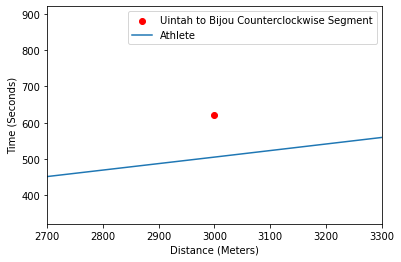

Athlete pace: 0:02:48.352144 m/km
Segment pace: 0:03:27 m/km


In [45]:
segment_id = "20223561"
segment_name = "Uintah to Bijou Counterclockwise"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


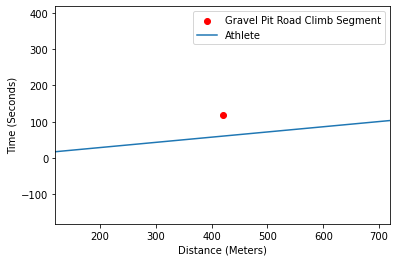

Athlete pace: 0:02:23.481941 m/km
Segment pace: 0:04:41.653905 m/km


In [46]:
segment_id = "5336817"
segment_name = "Gravel Pit Road Climb"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is slower than segment


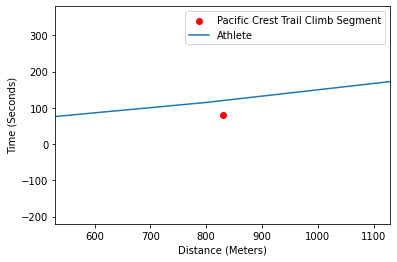

Athlete pace: 0:02:24.603779 m/km
Segment pace: 0:01:36.316048 m/km


In [47]:
segment_id = "4626685"
segment_name = "Pacific Crest Trail Climb"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


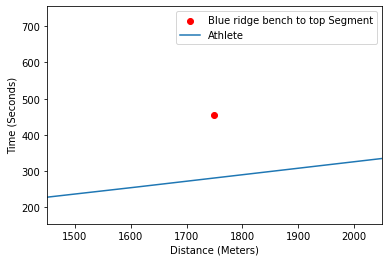

Athlete pace: 0:02:40.698097 m/km
Segment pace: 0:04:19.876571 m/km


In [48]:
segment_id = "8224741"
segment_name = "Blue ridge bench to top"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


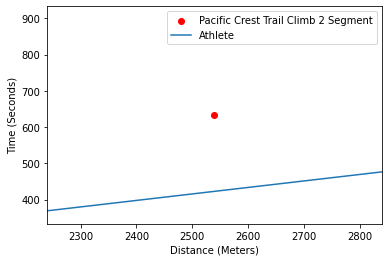

Athlete pace: 0:02:46.411937 m/km
Segment pace: 0:04:09.270457 m/km


In [49]:
segment_id = "1410421"
segment_name = "Pacific Crest Trail Climb 2"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


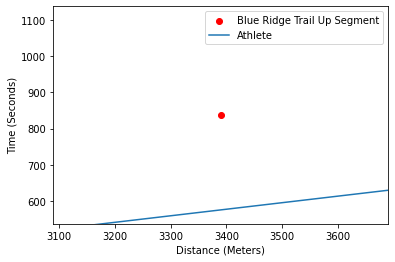

Athlete pace: 0:02:49.782731 m/km
Segment pace: 0:04:06.950997 m/km


In [50]:
segment_id = "8224705"
segment_name = "Blue Ridge Trail Up"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


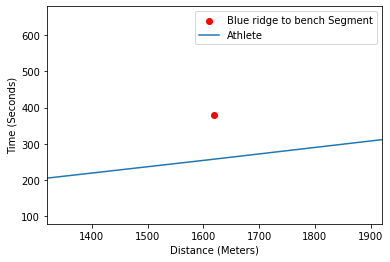

Athlete pace: 0:02:39.223230 m/km
Segment pace: 0:03:54.249580 m/km


In [51]:
segment_id = "8224728"
segment_name = "Blue ridge to bench"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


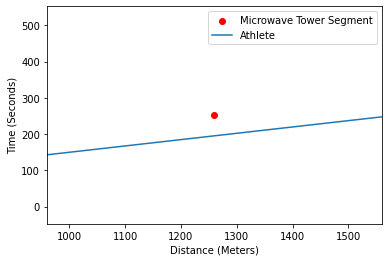

Athlete pace: 0:02:34.813093 m/km
Segment pace: 0:03:20.226603 m/km


In [52]:
segment_id = "9757372"
segment_name = "Microwave Tower"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_6728\2970963275.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


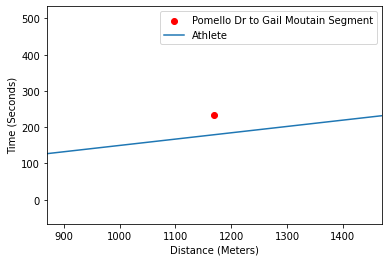

Athlete pace: 0:02:33.297220 m/km
Segment pace: 0:03:19.522308 m/km


In [53]:
segment_id = "6788952"
segment_name = "Pomello Dr to Gail Moutain"
get_athlete_v_segment(pr,segment_id,segment_name)

## Conclusions 
Looks like my alg predicted 9/10 segments correctly. The only one it didn't plot correctly had a huge amount of elevation gain over a very small distance. Looks like my GAP equation was a little agressive on that one. This alg will serve as a good baseline for comparing to Walt's DTW alg